## <center> Exercise number 1  

בתאל בן עזרא- 322740408  
שירה בן שמחון-  
חן בן ממס-

In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from statsmodels.formula.api import quantreg
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

## Question 1

read the data

In [2]:
data=pd.read_parquet("data1.parquet")

clean anomly points

In [3]:
filter_data=data[(data['x']<600)]
data_x=filter_data[['x']]
data_y=filter_data['y']


find y=a*x+b with linear regression

In [4]:
lr = LinearRegression()
lr.fit(data_x, data_y)
lr_predicted=lr.predict(data_x)
print(f'y = {lr.coef_[0]:.2f}*x + {lr.intercept_:.2f}')


y = 2.97*x + 70.02


find y=a*x+b with Deming Regression

delta is the ratio between the variance of the errors in y divided by the variance of the errors in x.

in our question is 1/2.

In [5]:
x_mean = data_x.mean()
y_mean = data_y.mean()

s_xy = ((data_x - x_mean).x * (data_y - y_mean)).sum() 
s_xx = ((data_x - x_mean)**2).sum()
s_yy = ((data_y - y_mean)**2).sum()

delta = 1/2

deming_slope = (s_yy - delta*s_xx + np.sqrt((s_yy - delta*s_xx)**2 + 4*delta*s_xy**2)) / (2*s_xy)
deming_intercept = y_mean - x_mean*deming_slope
dr_pridected = (data_x * deming_slope + deming_intercept).x


the deming regression better then linear regression

In [6]:
lr_err=r2_score(data_y, lr_predicted)
dr_err=r2_score(data_y, lr_predicted)
[lr_err,dr_err]

[0.8358081335811013, 0.8358081335811013]

plot the Linear Regression and the Deming Regression

compared to true point


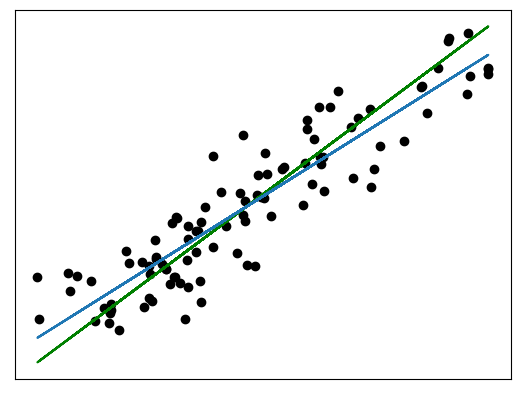

In [7]:
plt.scatter(data_x,data_y,color="black")
plt.plot(data_x.x,dr_pridected,color="green")
plt.plot(data_x.x,lr_predicted)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
dr_pridected.r

## Question 2

In [8]:
data=pd.read_parquet('data2.parquet',engine='pyarrow')
data.head()

,x,y
0,0.00000,10.248357
1,0.10101,9.974390
2,0.20202,10.490277
3,0.30303,11.143792
4,0.40404,10.037640


In [9]:
data.describe()

,x,y
count,100.000000,100.000000
mean,5.000000,12.247093
std,2.930454,3.277851
min,0.000000,2.636535
25%,2.500000,10.073236
50%,5.000000,11.579393
75%,7.500000,14.248710
max,10.000000,21.000932


## <center>modeling y as a function of x using linear regression

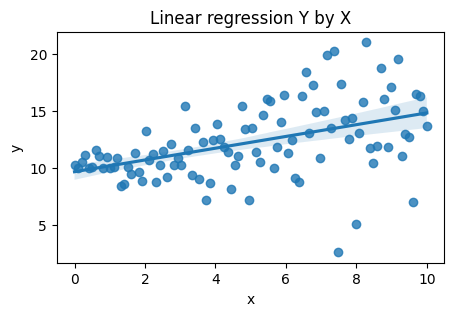

In [10]:
plt.figure(figsize=(5,3))
sns.regplot(data,x='x',y='y').set(title="Linear regression Y by X")
plt.show()

In [11]:
# fit simple linear regression model
OLS_model = ols('y ~ x',data=data).fit() 
# display model summary
print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     26.28
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.48e-06
Time:                        23:43:06   Log-Likelihood:                -248.23
No. Observations:                 100   AIC:                             500.5
Df Residuals:                      98   BIC:                             505.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.6752      0.581     16.660      0.0

In [12]:
predictions=OLS_model.fittedvalues
residuals=OLS_model.resid

## <center> Testing if the residuals meet the linear regression assumptions

### Normality assumption   
It is assumed that theresiduals are normally distributed

first-looking at the histogram  
It seems that the tail is not continuous with the other values

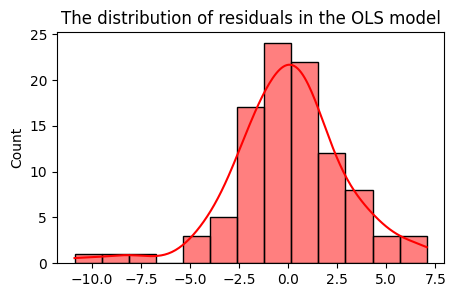

In [13]:
plt.figure(figsize=(5,3))
sns.histplot(residuals,kde=True,color='red').set(title="The distribution of residuals in the OLS model")
plt.show()

Here we looked at the outliers which apparently constitute the tail of the distribution

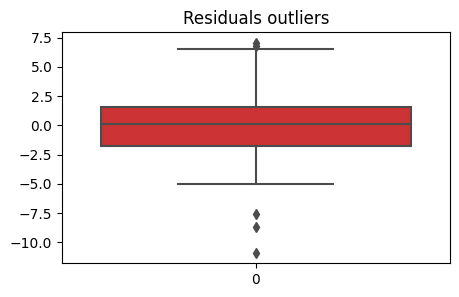

In [14]:
plt.figure(figsize=(5,3))
sns.boxplot(data=residuals,palette='Set1').set(title="Residuals outliers")
plt.show()

**The decisive test-“quantile-quantile”**

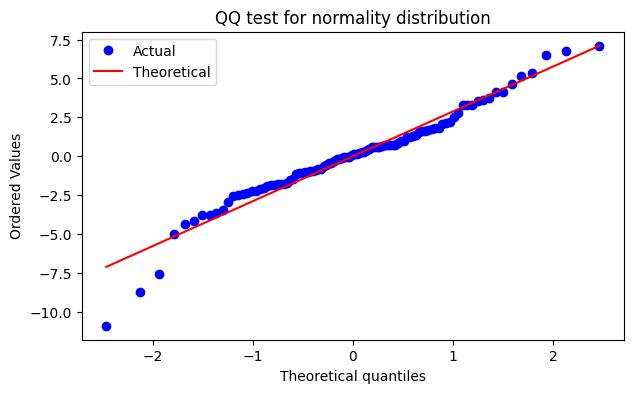

In [15]:
plt.figure(figsize=(7,4))
sc.stats.probplot(residuals,dist="norm",plot=plt)
plt.title("QQ test for normality distribution")
plt.legend(['Actual','Theoretical'])
plt.show()

If the data is normally distributed, the points in a Q-Q plot will lie on a straight diagonal line.  
Conversely, the more the points in the plot deviate significantly from a straight diagonal line, the less likely the set of data follows a normal distribution.  
We can see that the points lie mostly along the straight diagonal line with some  deviations along each of the tails.
Based on this plot, we could  assume that this  data is normally distributed.

### Zero mean assumption  
 It is assumed that the residuals have a mean value of zero, i.e., the error terms are normally distributed around zero.
 

In [16]:
print("The residuals mean:",np.mean(residuals))

The residuals mean: 6.217248937900876e-16


The residuals mean is almost equal to zero, this is a sufficient approximation to determine that the assumption has been met

### Homoscedasticity

Homoscedasticity means that the residuals have equal or almost equal variance across the regression line. By plotting the error terms(residuals) with predicted terms ( the labels) we can check that there should not be any pattern in the error terms.  
If there is a definite pattern (like quadratic or funnel shaped) obtained from the scatter plot then heteroscedasticity is present.

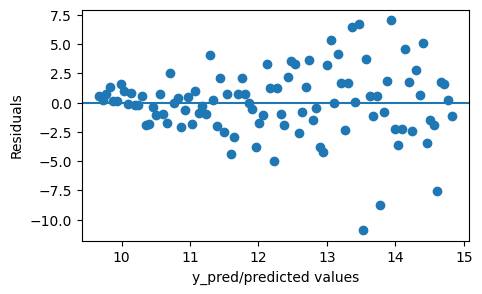

In [17]:
plt.figure(figsize=(5,3))
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.scatter(predictions,residuals)
plt.axhline(0)
plt
plt.show()

We can see that the residual are spread at a high value of x- wich mean heteroscedasticity.  
to be sure we used the withe test and Breusch-Pagan test:  
Null (H0): Homoscedasticity is present (residuals are equally scattered)  
Alternative (HA): Heteroscedasticity is present (residuals are not equally scattered)

**White test**

In [18]:
white_test = het_white(residuals, OLS_model.model.exog)
print("lm :", white_test[0],"lm_pvalue:", white_test[1])

lm : 11.019456296116982 lm_pvalue: 0.004047207474894136


Since the p-value is less then 0.05, we  reject the null hypothesis and conclude that heteroscedasticity is present in the regression model.

**Breusch-Pagan test**

In [19]:
bptest_test = het_breuschpagan(residuals, OLS_model.model.exog)
print("lm :", bptest_test[0],"lm_pvalue:", bptest_test[1])

lm : 10.673778282992652 lm_pvalue: 0.0010866493368004257


Here we also get a p-value smaller than 0.05,hence we don't reject the null hypothesis

### Quantile regression

In [20]:
quantile_model_1 =quantreg("y ~ x", data).fit(q=0.05)
quantile_model_2 =quantreg("y ~ x", data).fit(q=0.5)
quantile_model_3 =quantreg("y ~ x", data).fit(q=0.95)

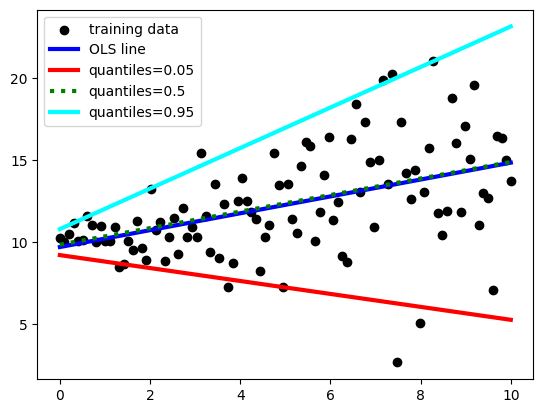

In [21]:
plt.scatter(data.x,data.y,  color='black',label='training data')
plt.plot(data.x, predictions, color='blue',
         linewidth=3, label='OLS line')
plt.plot(data.x,quantile_model_1.fittedvalues,color='red',linewidth=3,label='quantiles=0.05')
plt.plot(data.x,quantile_model_2.fittedvalues,'g:',linewidth=3,label='quantiles=0.5')
plt.plot(data.x,quantile_model_3.fittedvalues,color='cyan',linewidth=3,label='quantiles=0.95')

plt.legend()
plt.show()

ברגרסיה רגילה (OLS) אנו ממזערים את סכום ריבועי השגיאות (RSS) או את ממוצע ריבועי השגיאות (RMS) ומקבלים את קו הרגרסיה המתאים ביותר ל data שלנו- בהנחה וההנחות הנדרשות בעת שימוש ברגרסיה ליניארית מתקיימות.  
בשיטה זו אנו מקבלים את הממוצע המותנה של משתנה המטרה(y)על פני המשתנים המנבאים (X): 

<center>$Y_{i}=\hat{Y}_{i}+\epsilon_{i}$
<center>$\hat{Y}=\mu_{(Y_|x_{i})}= \hat{\theta}_{0} + \sum \limits _{i=1} ^{p} X_{i}\hat{\theta}_{i}$
<center>$Y_{i}=\mu_{(Y_|x_{i})}+\epsilon_{i}$

כך בהינתן x מסוים שעבורו נרצה לחזות את y, קו הרגרסיה נותן לנו את הממוצע של כלל האוכלוסיה בהינתן אותו x.  
לשיטה זו יש כמה חסרונות:בראש ובראשונה, לא ניתן להשתמש בה כאשר אחת ההנחות שיש להניח בעת שימוש ברגרסיה ליניארית לא מתממשות.  
מעבר לזה בהרבה מקרים בכלל לא נהיה מעוניינים בממוצע(אלא אולי בחציון או באחוזון אחר) הוא חסר משמעות עבורינו ואין לנו אפשרות לקבוע רמת ביטחון עבור הפרדיקציות.   
במקרים כאלו נשתמש ב - Quantile regression שהיא הרחבה לרגרסיה ליניארית.   
התהליך למציאת קו הרגרסיה המתאים ביותר דומה מאוד לרגרסיה ליניארית רק שבשיטה זו נמזער סכום משוקלל של השגיאה השלילית והחיובית ונקבל את החציון/האחוזון המותנה של משתנה המטרה על פני המשתנים המנבאים. 

קו הרגרסיה המתקבל עבור $\tau$ מסוים כאשר $0<\tau<1$: 

<center>$Q_{\tau}(y_{i})=\theta_{0}(\tau)+\theta_{1}(\tau)x_{i1}+...+\theta_{p}(\tau)x_{ip}$

ה- Loss function  ב Quantile regression:

<center>$L_{\tau}(Y_{i},\hat{Y}_{i}|\tau)=\sum \limits _{i=1} ^{n} p_{\tau}(Y_{i}-\hat{Y}_{i}|\tau),$ 

<center>$P_{\tau}(u)=\tau \max(u,o)+(1-\tau)\max(-u,0)$

כמו שהוזכר, quantile regression מיושמת כאשר התנאים שיש להניח בעת שימוש ברגרסיה ליניארית לא מתממשים או כאשר מעוניינים לקבל הסתכלות רחבה יותר מעבר לממוצע. כמו כן quantile regression רגישה יותר ל outlaiers  וקו הרגרסיה לא יושפע מהם כמו שהוא מושפע ברגרסיה ליניארית(בגלל שהיא מסתכלת על חציון/ אחוז מסוים ולא ממוצע שכידוע מושפע מערכי קיצון). בנוסף, שימוש ב quantile regression נעשה בתחומים רבים כגון בכלכלה ופיננסים (לחישוב  value at risk),רפואה ואקולוגיה. 

## Question 3

In [22]:
data=pd.read_parquet('data3.parquet',engine='pyarrow')
data.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,label
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [23]:
data.describe()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,label
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [24]:
x=data.drop(['label'],axis=1)
y=data['label']

In [25]:
alphas=np.arange(0,1.01,0.01)

In [26]:
parameters = {'alpha':alphas}

In [27]:
cv=RepeatedKFold(n_splits=10, n_repeats=3,random_state=1)

In [28]:
result=GridSearchCV(Ridge(),parameters, scoring='neg_mean_absolute_error',cv=cv).fit(x,y)

In [29]:
print('Best Score: %s' % result.best_score_)

Best Score: -3.3788297594275507


In [30]:
print('Best Hyperparameters: %s' % result.best_params_)

Best Hyperparameters: {'alpha': 0.51}
